In [1]:
from typing import List, Tuple, Union
from tensorflow.python.keras import callbacks, Sequential, layers, Model
import glob
import os
from scipy.io.wavfile import read
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import midiDriver
import audioRecorder


CHECKPOINT_FILEPATH = './checkpoints'


def esr(signal_a, signal_b) -> float:
    '''Returns the Error-to-Signal Ratio.

    Keyword arguments:
    signal_a -- the groundtruth signal
    signal_b -- the predicted signal
    '''
    power = 2.0
    numerator = np.sum(np.power(np.subtract(signal_a, signal_b), power))
    denominator = np.sum(np.power(signal_a, power))
    return np.divide(numerator, denominator)
    

def normalize(array: Union[List,ndarray], scale_max: int=1, scale_min: int=0) -> List:
    '''Returns a normalized array.
    
    Keyword arguments:
    array -- array to normalize
    scale_max -- maximum value to scale between
    scale_min -- minimum value to scale between
    '''
    scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
    return scaler.fit_transform(array)


def partition_dataset(data_path: str='data/simple_dataset/01/*', train_perc: float=0.8) -> Tuple[List, List, List, List]: 
    '''Partition into train, train_labels & test, test_labels datasets.

    Keyword arguments:
    data_path -- where the data lives
    '''
    assert train_perc < 1, 'train_perc must be less than 1'
    data_paths = glob.glob(data_path)
    split_idx = int(0.8 * len(data_paths))
    train_paths, test_paths = data_paths[:split_idx], data_paths[split_idx:]
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    for file in train_paths:
        _, data = read(file)
        train_data.append(data)
        train_labels.append(os.path.basename(file).split('.')[0])
    for file in test_paths:
        _, data = read(file)
        test_data.append(data)
        test_labels.append(os.path.basename(file).split('.')[0])
    return train_data, train_labels, test_data, test_labels


def make_model(input_shape: Tuple[int, int], num_output_nodes: int=3) -> Sequential:
    '''Return a model.
    
    Keyword arguments:
    input_shape -- dimension of input features
    num_output_nodes -- number of nodes of the output layer
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),
        # units = 8 is a value taken from https://arxiv.org/pdf/2009.02833.pdf
        Conv1D(filters=32, kernel_size=3, activation='relu'), 
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        # Flatten(),
        # Dense(10),
        GRU(units=8, return_sequences=True), 
        Dense(num_output_nodes)
    ])
    return model

In [2]:
# load features, labels and label de-normalization weights
CSV_PATH = './data/preprocessed/'
CSV_FILENAME = 'datasetFeat&LabelL2Norm2022-05-17 13:05:26.csv'
SIMPLE_DATASET_PATH = './data/simple_dataset'
LABEL_DENORM_WEIGHTS_FILENAME = 'label_denorm_weights.pkl'
# CSV_FILENAME = 'datasetFeatNorm2022-05-13 14:44:10.csv'

df = pd.read_csv(CSV_PATH + CSV_FILENAME)
# X = [eval(feature_str) for feature_str in df['features']]
# X = np.asarray(X)
X = df.loc[:, 'mfcc1':'sc21'].values

# y = [eval(label_str) for label_str in df['labels']]
# y = np.asarray(y)
y = df.loc[:, 'label1':'label3'].values

import pickle
with open(f'{SIMPLE_DATASET_PATH}/{LABEL_DENORM_WEIGHTS_FILENAME}', 'rb') as f:
    label_denorm_weights = pickle.load(f)

In [3]:
# partition dataset into 60% train, 20% val, 20% test
split_seed: int = 42
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, shuffle=False)
print(f'{x_train.shape=} {x_val.shape=} {x_test.shape=}')

x_train.shape=(600, 43) x_val.shape=(200, 43) x_test.shape=(200, 43)


In [4]:
# architect model
num_labels = y.shape[1]
input_shape = X.shape[1]

# librosa features head
libosa_inputs = layers.Input(shape=input_shape, name='librosa features')
x = layers.Dense(128, activation='relu')(libosa_inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation='relu')(x)
block_1_output = layers.Dropout(0.5)(x)
# block 2
x = layers.Dense(16, activation='relu', name='2')(block_1_output)
x = layers.Dropout(0.5)(x)
block_2_output = layers.add([x, block_1_output])
# block 3
x = layers.Dense(16, activation='relu', name='3')(block_2_output)
x = layers.Dropout(0.5)(x)
block_3_output = layers.add([x, block_2_output])
# block 4
x = layers.Dense(16, activation='relu', name='4')(block_3_output)
x = layers.Dropout(0.5)(x)
block_4_output = layers.add([x, block_3_output])
# block 5
x = layers.Dense(16, activation='relu', name='5')(block_4_output)
x = layers.Dropout(0.5)(x)
block_5_output = layers.add([x, block_4_output])
# block 6
x = layers.Dense(16, activation='relu', name='6')(block_5_output)
x = layers.Dropout(0.5)(x)
block_6_output = layers.add([x, block_5_output])
# block 7
x = layers.Dense(16, activation='relu', name='7')(block_6_output)
x = layers.Dropout(0.5)(x)
block_7_output = layers.add([x, block_6_output])
# output block
output_block = layers.Dense(num_labels, name='output')(block_7_output)
# model definition
model = Model(inputs=[libosa_inputs], outputs=[output_block], name='functional')

# visualize model 
from keras.utils.all_utils import plot_model
# plot_model(model, show_shapes=True, rankdir='TB', to_file='model.png', dpi=100)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-17 13:36:19.495470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-17 13:36:19.495580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# train the model
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
PARAMS = {
    'opt' : RMSProp(learning_rate=0.001), # 0.002:742, 0.003:612, 0.004:668, 0.006:605
    'loss' : 'mse',
    'bs' : 64,
    'epochs' : 200, # 500 became stagnant around 220 with lr=0.001
    'metrics' : []
}
model.compile(loss=PARAMS['loss'], metrics=PARAMS['metrics'], optimizer=PARAMS['opt'])

# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     save_best_only=True, save_weights_only=False, 
#     filepath=CHECKPOINT_FILEPATH, monitor='val_loss', mode='auto')
reduce_lr_callback = callbacks.ReduceLROnPlateau(patience=50, monitor='val_loss', factor=0.1, mode='min')

history = model.fit(
    x_train, y_train, batch_size=PARAMS['bs'], 
    epochs=PARAMS['epochs'], validation_data=(x_val, y_val), 
    verbose=1,) # callbacks=[reduce_lr_callback])

Epoch 1/200


2022-05-17 13:36:19.625575: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-17 13:36:20.048291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 33ms/step - loss: 0.0453 - val_loss: 6.1351e-04
Epoch 2/200
 6/10 [=================>............] - ETA: 0s - loss: 0.0043

2022-05-17 13:36:20.644628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 17ms/step - loss: 0.0036 - val_loss: 5.0852e-04
Epoch 3/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 4.2276e-04
Epoch 4/200
10/10 [==============================] - 0s 14ms/step - loss: 8.1498e-04 - val_loss: 3.5848e-04
Epoch 5/200
10/10 [==============================] - 0s 14ms/step - loss: 6.4030e-04 - val_loss: 2.9255e-04
Epoch 6/200
10/10 [==============================] - 0s 14ms/step - loss: 5.3285e-04 - val_loss: 2.5975e-04
Epoch 7/200
10/10 [==============================] - 0s 14ms/step - loss: 4.4034e-04 - val_loss: 2.4233e-04
Epoch 8/200
10/10 [==============================] - 0s 14ms/step - loss: 3.1386e-04 - val_loss: 2.5004e-04
Epoch 9/200
10/10 [==============================] - 0s 14ms/step - loss: 2.8377e-04 - val_loss: 2.5208e-04
Epoch 10/200
10/10 [==============================] - 0s 15ms/step - loss: 2.7656e-04 - val_loss: 2.3432e-04
Epoch 11/200
10/10 [===========================

Final Training Loss: 0.000124
Final Testing Loss: 0.000124


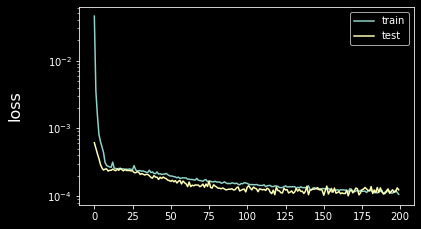

In [7]:
# plot the model training loss
print("Final Training Loss: {0:.3}".format(history.history['val_loss'][-1]))
print("Final Testing Loss: {0:.3}".format(history.history['val_loss'][-1]))

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
# source: https://stackoverflow.com/questions/31810461/python-matplotlib-vertically-aligned-plots-in-matplotlib

gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(6,8))

#first plot
ax = fig.add_subplot(gs[0])
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_yscale('log')
ax.set_ylabel(r'loss', size=16)
ax.get_yaxis().set_label_coords(-0.17,0.5)
ax.legend(['train', 'test'], loc='upper right')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    labelbottom='off') # labels along the bottom edge are off

#second plot
if 'lr' in history.history:
    ax = fig.add_subplot(gs[1], sharex=ax)
    ax.plot(history.history['lr'])
    ax.set_ylabel(r'learning rate', size =16)
    ax.get_yaxis().set_label_coords(-0.17,0.5)

plt.show()

In [13]:
# compare model performance to ground truth
n = 5

# normalized 
print(f'ground truth normalized:\n{y_test[0:n]}')
predictions = model.predict(x=x_test[0:n], batch_size=64)
print(f'model predictions:\n{predictions}')
print()

# de normalized
denormalized_gt = y_test[0:n] * label_denorm_weights
print(f'ground truth after denormalization:\n{denormalized_gt}')
denormalized_p = predictions[0:n] * label_denorm_weights
print(f'model predictions after denormalization:\n{denormalized_p}')

ground truth normalized:
[[0.04356077 0.04478844 0.00042842]
 [0.04051152 0.01894896 0.02227766]
 [0.00043561 0.00732119 0.00342733]
 [0.02221599 0.00645987 0.01199567]
 [0.0396403  0.02756212 0.00214208]]
model predictions:
[[0.03001376 0.03782009 0.01497176]
 [0.02522312 0.02500076 0.02599248]
 [0.01287588 0.02142769 0.02199091]
 [0.01805067 0.0171716  0.02333452]
 [0.02348093 0.03470502 0.01677625]]

ground truth after denormalization:
[[100. 104.   1.]
 [ 93.  44.  52.]
 [  1.  17.   8.]
 [ 51.  15.  28.]
 [ 91.  64.   5.]]
model predictions after denormalization:
[[68.90088953 87.81929913 34.94673298]
 [57.90328917 58.05246322 60.67104748]
 [29.55843668 49.75568906 51.3306704 ]
 [41.43789155 39.87291745 54.46688841]
 [53.9038469  80.58602277 39.15873467]]
